In [1]:
import matplotlib.pyplot as plt
# import sys
plt.style.use('Solarize_Light2')

import os


args = 2
os.environ['CUDA_VISIBLE_DEVICES'] = f'{args}'
print(f'Selected GPU {args}')

import jax
import jax.random as jrnd
import jax.numpy as jnp
import distrax as dx
import jaxkern as jk

from jax.config import config
config.update("jax_enable_x64", True)  # crucial for Gaussian processes

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

from uicsmodels.gaussianprocesses.fullgp import FullLatentGPModel, FullMarginalGPModel

Selected GPU 2


In [2]:
import sys
sys.path.append('/home/davcic/CP_Testing')

from New_kernel_1 import Discontinuous_multiple
from New_kernel_1 import Discontinuous_multiple_params
from New_kernel_1 import Discontinuous_multiple_params_hyper
from Poisson_Process_added import Poisson_Process_hyper
from fullgp import FullMarginalGPModelhyper_mult
from Uniform_modified import Uniform_mod
from Normal_modified import LogNormal_mod
from fullgp import FullLatentGPModelhyper_mult

In [16]:
from fullgp import FullLatentGPModelhyper_mult

def model_latent(x, y, key):
    # %%time
    size = 20
    T = 1
    max_CP = size
    base_kernel = jk.RBF()
    kernel = Discontinuous_multiple_params_hyper(base_kernel)

    priors = dict(kernel=dict(lengthscale=LogNormal_mod(0, 3, max_CP+1),
                            variance=LogNormal_mod(0.5, 1, max_CP+1), 
                            num=Poisson_Process_hyper(size, T)
                                                                ),
                likelihood=dict(obs_noise=dx.Transformed(dx.Normal(loc=0.,
                                                                    scale=1.),
                                                        tfb.Exp())),
                hyper = dict(hyper_pp = dx.Transformed(dx.Normal(loc=1.,
                                                                scale=1.),
                                                        tfb.Exp())))

    gp_latent = FullLatentGPModelhyper_mult(x, y, cov_fn=kernel, priors=priors)  # Implies likelihood=Gaussian()

    num_particles = 1000
    num_mcmc_steps = 100
    key, gpm_key = jrnd.split(key)
    lgp_particles, _, lgp_marginal_likelihood = gp_latent.inference(gpm_key,
                                                                    mode='gibbs-in-smc',
                                                                    sampling_parameters=dict(num_particles=num_particles, num_mcmc_steps=num_mcmc_steps),
                                                                    poisson = True)
    return gp_latent, lgp_particles

In [17]:
def plot_post(gp_particles, ground_truth):
  trainables = ['lengthscale', 'variance']

  num_params = len(trainables)

  symbols = dict(lengthscale='\ell',
              variance=r'\tau')
  num_CP = 4
  _, axes = plt.subplots(nrows=num_params, ncols=num_CP+1, constrained_layout=True,
                      figsize=(12, 6))


  particles = gp_particles
  tr = dict(lengthscale=particles.particles['kernel']['lengthscale'],
              variance=particles.particles['kernel']['variance'],
              )
  for j, var in enumerate(trainables):
      pd = tr[var]
      for i in range(num_CP+1):
        # There are some outliers that skew the axes
        pd_u, pd_l = jnp.nanpercentile(pd[:, i], q=99.9), jnp.nanpercentile(pd[:, i], q=0.1)
        pd_filtered = jnp.extract(pd[:, i]>pd_l, pd[:, i])
        pd_filtered = jnp.extract(pd_filtered<pd_u, pd_filtered)
        axes[j, i].hist(pd_filtered[~jnp.isnan(pd_filtered)], bins=30, density=True, color='tab:blue')
        # axes[j, i].hist(pd[:, i][~jnp.isnan(pd[:, i])], bins=30, density=True, color='tab:blue')
        axes[j, i].axvline(x=ground_truth[var][i], ls=':', c='k')

        if var in symbols:
            axes[j, i].set_xlabel(r'${:s}$'.format(symbols[var]+ str(i)))

  
  num_particles = particles.particles['kernel']['lengthscale'].shape[0]
  plt.suptitle(f'Posterior estimate of Bayesian GP ({num_particles} particles)');

  axes[0, 0].set_ylabel('lengthscale', rotation=0, ha='right')
  axes[1, 0].set_ylabel('variance', rotation=0, ha='right')

In [18]:
def plot_fit(gp, gp_particles, x, y, f_true, key):   
    x_pred = jnp.linspace(0, 1, num=100)
    # x_pred = jnp.linspace(-0.25, 1.25, num=150)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4), sharex=True,
                                sharey=True, constrained_layout=True)


    key, key_pred = jrnd.split(key)
    f_pred = gp.predict_f(key_pred, x_pred)

    pd = gp_particles.particles['kernel']['num']
    # There are some outliers that skew the axis
    # pd_u, pd_l = jnp.percentile(pd, q=99.9), jnp.percentile(pd, q=0.1)
    # pd_filtered = jnp.extract(pd>pd_l, pd)
    # pd_filtered = jnp.extract(pd_filtered<pd_u, pd_filtered)

    num_particles = gp_particles.particles['kernel']['num'].shape[0]
    ax = axes[0]
    for i in jnp.arange(0, num_particles, step=10):
        ax.plot(x_pred, f_pred[i, :], alpha=0.1, color='tab:blue')

    new_pd = pd[jnp.logical_not(jnp.isnan(pd))]
    # kde = stats.gaussian_kde(new_pd)
    ax2 = ax.twinx()
    # ax2.plot(x_pred, kde(x_pred))
    ax2.hist(new_pd, bins=30, density=True, color='tab:blue', alpha=0.5)

    ax = axes[1]
    f_mean = jnp.nanmean(f_pred, axis=0)
    y_pred = gp.predict_y(key_pred, x_pred)
    f_hdi_lower = jnp.percentile(y_pred, q=2.5, axis=0)
    f_hdi_upper = jnp.percentile(y_pred, q=97.5, axis=0)
    # f_hdi_lower = jnp.percentile(f_pred, q=2.5, axis=0)
    # f_hdi_upper = jnp.percentile(f_pred, q=97.5, axis=0)

    ax.plot(x_pred, f_mean, color='tab:blue', lw=2)
    ax.fill_between(x_pred, f_hdi_lower, f_hdi_upper,
                    alpha=0.2, color='tab:blue', lw=0)

    #print(new_pd.shape)
    ax2 = ax.twinx()
    # ax2.plot(x_pred, kde(x_pred))
    ax2.hist(new_pd, bins=30, density=True, color='tab:blue', alpha=0.5)
    ax2.set_ylabel('CP probability', fontsize=16)

    for ax in axes.flatten():
        ax.plot(x, f_true, 'k', label=r'$f$')
        ax.plot(x, y, 'rx', label='obs')
        ax.set_xlim([-0., 1])
        ax.set_ylim([-5.5, 5.5])
        ax.set_xlabel(r'$x$', fontsize=12)

    axes[0].set_title('SMC particles', fontsize=16)
    axes[1].set_title('Posterior 95% HDI', fontsize=16)

    axes[0].set_ylabel('Latent GP', rotation=0, ha='right', fontsize=14)

In [19]:
def plot_num(lgp_particles):
    fig = plt.figure(figsize=(12, 6))
    num_val = lgp_particles.particles['kernel']['num']
    counts = jnp.count_nonzero(~jnp.isnan(num_val), axis = 1)
    uni_vals = jnp.sort(jnp.concatenate([jnp.unique(counts)-0.5, jnp.unique(counts)+0.5]))
    plt.hist(counts, bins=uni_vals, rwidth = 0.5)
    plt.xlabel("Amount of change points")
    plt.ylabel("Amount of particles")
    plt.show()

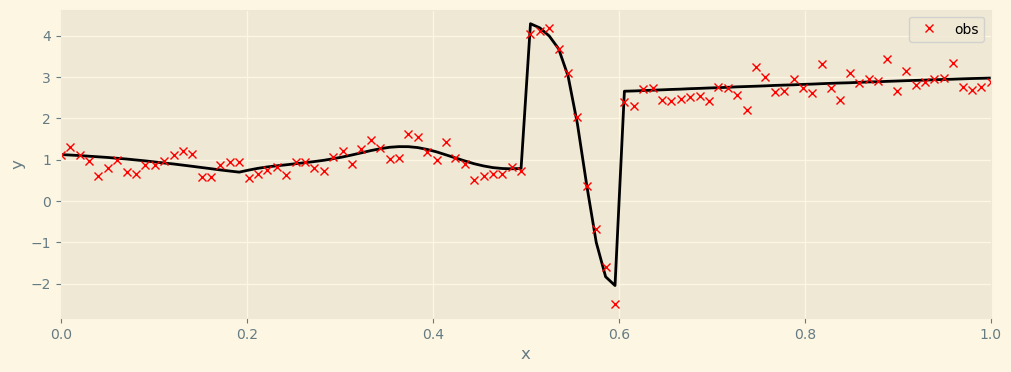

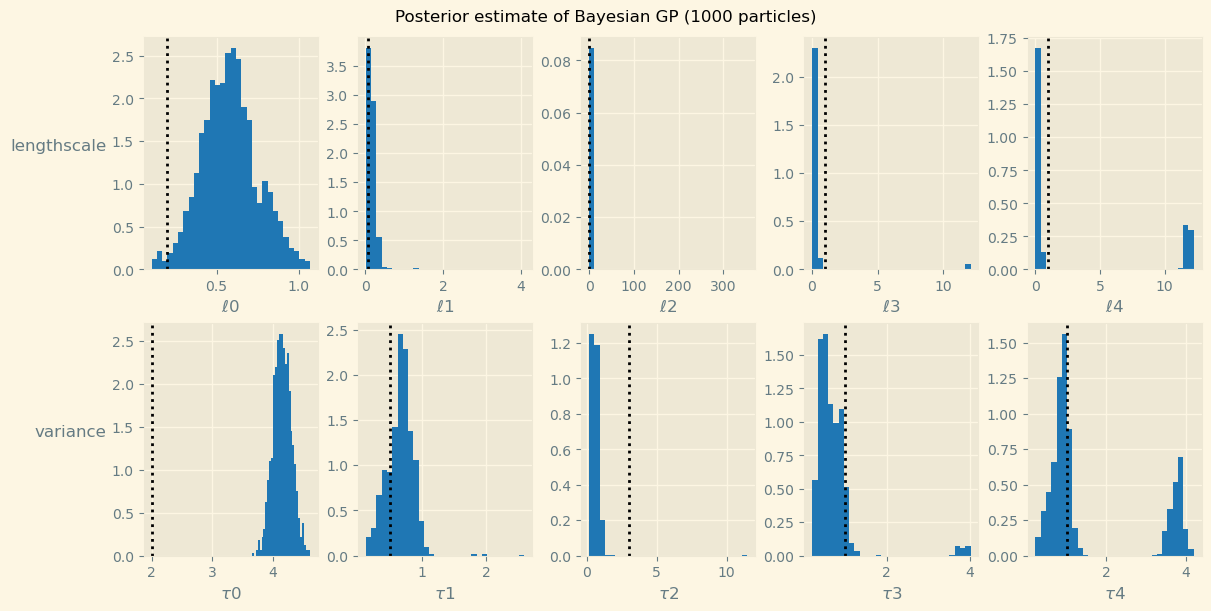

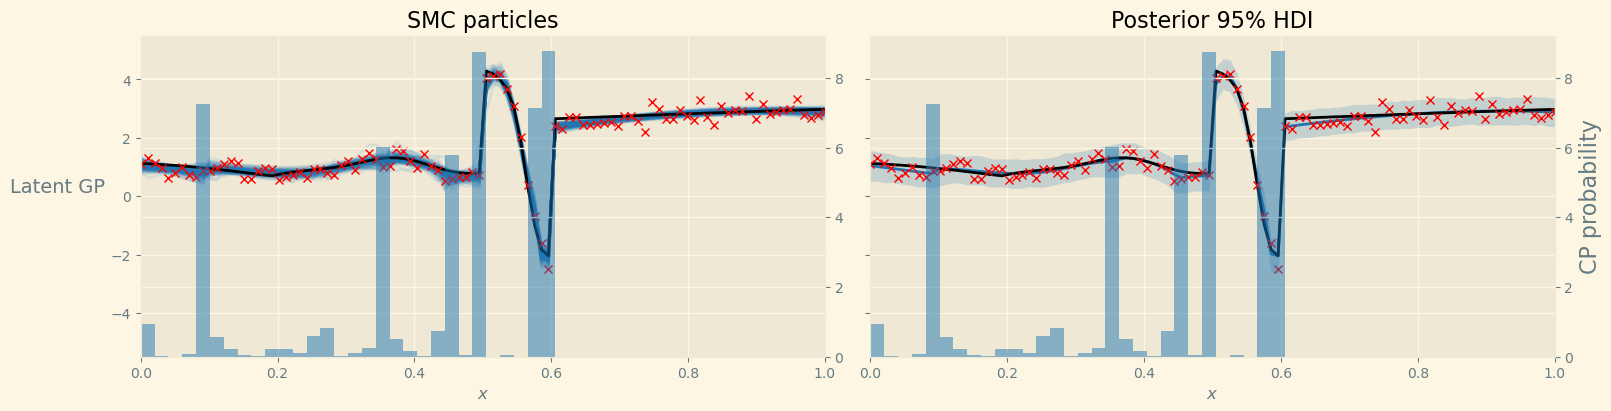

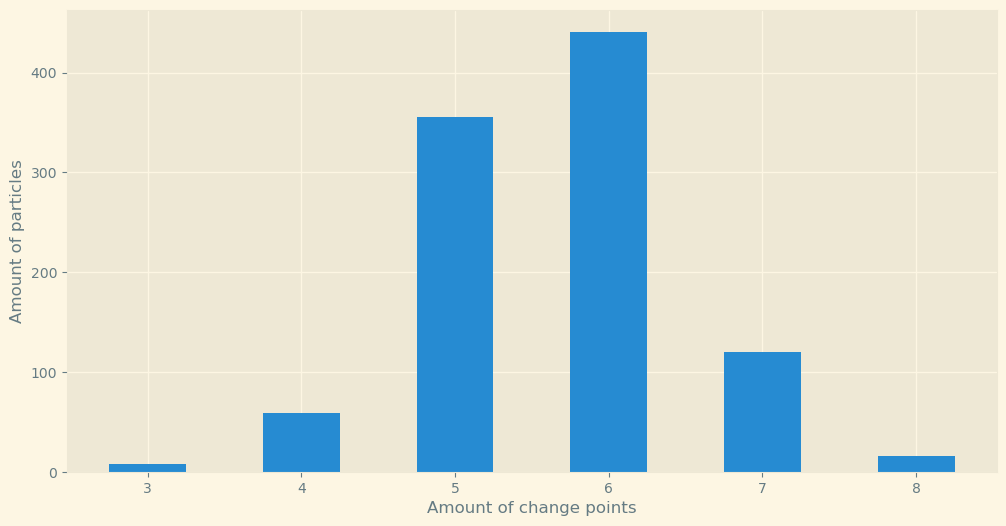

: 

In [20]:
'''DATASET 1'''
key = jrnd.PRNGKey(1234)

lengthscale_ = jnp.array([0.2, 0.08, 0.03, 1])
output_scale_ = jnp.array([2, 0.5, 3, 1])
obs_noise_ = 0.2
n = 100
x = jnp.linspace(0, 1, n)[:, jnp.newaxis]
x0 = jnp.array([0.2, 0.5, 0.6])
# x0 = jnp.concatenate((jnp.array([0]), x0, jnp.array([x.shape[0]])))
#x0 = jnp.append(jnp.zeros(1), x0, jnp.array(x.shape[0]))
base_kernel = jk.RBF()
kernel = Discontinuous_multiple_params(base_kernel, x0)
K = kernel.cross_covariance(params=dict(lengthscale=lengthscale_,
                                        variance=output_scale_,
                                        num=x0),
                            x=x, y=x)+ 1e-6*jnp.eye(n)

L = jnp.linalg.cholesky(K)
z = jrnd.normal(key, shape=(n,))

f_true = jnp.dot(L, z) + jnp.ones_like(z)
key, obs_key = jrnd.split(key)
y = f_true + obs_noise_*jrnd.normal(obs_key, shape=(n,))

ground_truth = dict(f=f_true,
                    lengthscale=lengthscale_,
                    variance=output_scale_,
                    obs_noise=obs_noise_)

plt.figure(figsize=(12, 4))
plt.plot(x, f_true, 'k', label=r'')
plt.plot(x, y, 'rx', label='obs')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([0., 1.])
plt.legend();

gp_latent, lgp_particles = model_latent(x, y, key)
plot_post(lgp_particles, ground_truth)
plot_fit(gp_latent, lgp_particles, x, y, f_true, key)
plot_num(lgp_particles)